In [1]:
!pip install h5py

In [1]:
import matplotlib.pyplot as plt

In [25]:
import h5py
import pandas as pd
import numpy as np 
from scipy.signal import butter,filtfilt

# Battleplan

- Biblio pour voir les features classiques en EEG 
- Regarder du côté FFT, MFCC, DWT
- stats desc pour chaque feature
- trouver features invariantes par individu? 
- deeeeeep 
- filtering 
- preprocessing & cleaning: que faire des différentes channels? 
- trois types de features: temporelles, domaine de fréquence, entropie

# 1. Dataviz

In [14]:
f = h5py.File('X_train.h5','r')

In [15]:
f.keys()

<KeysViewHDF5 ['features']>

In [16]:
df = f['features']
df.shape

(946, 40, 7, 500)

In [17]:
df[0,0:5,1,:].shape

(5, 500)

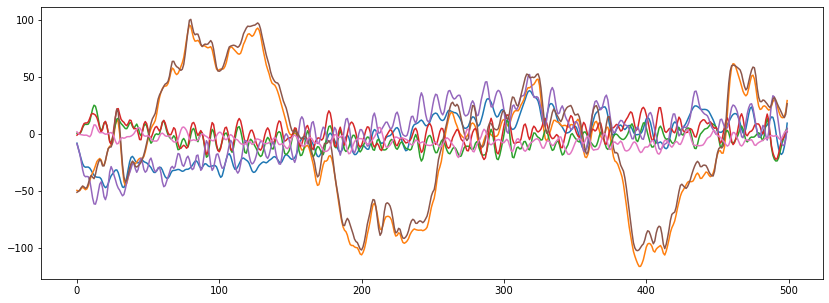

In [18]:
#display first eeg of each channels for patient 0
plt.figure(figsize=(14,5))
plt.plot(df[43,0,:,:].T)
plt.show()

In [93]:
ytrain = pd.read_csv('y_train.csv')

In [21]:
np.unique(ytrain['label'],return_counts=True)

(array([0, 1]), array([737, 209]))

# 2. Some features ideas

In [32]:
def getHjorthActivity(sig):
    return np.var(sig)

def getHjorthMobility(sig):
    dsig = sig[1:]-sig[:-1] #first order derivative
    return np.sqrt(np.var(dsig)/np.var(sig))

def getHjorthComplexity(sig):
    dsig = sig[1:]-sig[:-1]
    return getHjorthMobility(dsig)/getHjorthMobility(sig)

In [69]:
class EEG():
    def __init__(self,signal,label):
        self.signal = signal
        self.clean_signal = None
        self.label = label
        self.sampling_freq = 250
        self.hjorth_extracted = False
        self.mobility = None
        self.activity = None
        self.complexity = None
        
        
    def clean(self):
        #2nd order butterworth filter
        b,a = butter(2,Wn = (1,50),btype='bandpass',fs = self.sampling_freq) #gross filtering
        self.clean_signal = np.zeros(self.signal.shape)
        for i in range(self.signal.shape[0]):
            self.clean_signal[i,:] = filtfilt(b,a,self.signal[i,:])
        
    def extractHjorthFeatures(self):
        if self.clean_signal is None:
            self.clean()
        
        #activity = []
        #mobility = []
        #complexity = []
        #for i in range(self.clean_signal.shape[0]):
        #    activity.append(getHjorthActivity(self.clean_signal[i,:]))
        #    mobility.append(getHjorthMobility(self.clean_signal[i,:]))
        #    complexity.append(getHjorthComplexity(self.clean_signal[i,:]))
        
        activity = np.apply_along_axis(getHjorthActivity,1,self.clean_signal)
        mobility = np.apply_along_axis(getHjorthMobility,1,self.clean_signal)
        complexity = np.apply_along_axis(getHjorthComplexity,1,self.clean_signal)
        
            
        self.hjorth_extracted = True
        self.mobility = mobility
        self.activity = activity
        self.complexity = complexity
        return activity,mobility,complexity
    
    def hjorthViz(self):
        if not self.hjorth_extracted: 
            self.extractHjorthFeatures()
        if label == 0:
            c='b'
        else: 
            c='m'
            
        fig,(ax1,ax2,ax3) = plt.subplots(1,3)
        ax1.hist(self.mobility,c=c)
        ax1.set_title('Mobility')
        ax2.hist(self.activity,c=c)
        ax2.set_title('Activity')
        ax3.hist(self.complexity,c=c)
        ax3.set_title('Complexity')
    
        

In [44]:
act = []
mob = []
comp = []
for i in range(100):
    print(i)
    for j in range(df.shape[1]):
        eeg = EEG(df[i,j,:,:],ytrain['label'][i])
        a,m,c = eeg.extractHjorthFeatures()
        act.append(np.mean(a))
        mob.append(np.mean(m))
        comp.append(np.mean(c))
act,mob,comp = np.array(act),np.array(mob),np.array(comp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0.5, 1.0, 'Complexity')

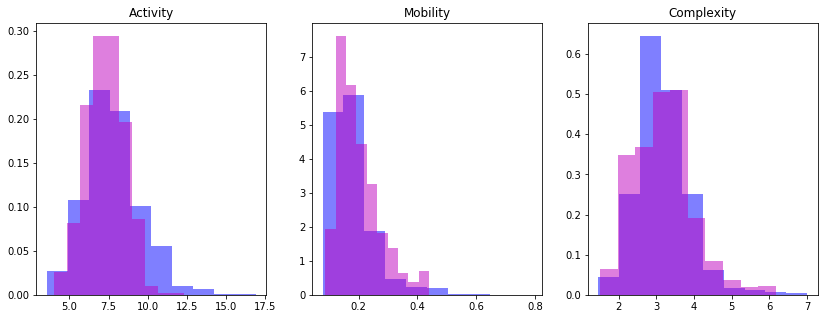

In [61]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,5))
ax1.hist(np.log(act)[np.repeat(ytrain['label'][:100]==0,40)],color='b',density=True,alpha=0.5)
ax1.hist(np.log(act)[np.repeat(ytrain['label'][:100]==1,40)],color='m',density=True,alpha=0.5)
ax1.set_title('Activity')
ax2.hist(mob[np.repeat(ytrain['label'][:100]==0,40)],color='b',density=True,alpha=0.5)
ax2.hist(mob[np.repeat(ytrain['label'][:100]==1,40)],color='m',density=True,alpha=0.5)
ax2.set_title('Mobility')
ax3.hist(comp[np.repeat(ytrain['label'][:100]==0,40)],color='b',density=True,alpha=0.5)
ax3.hist(comp[np.repeat(ytrain['label'][:100]==1,40)],color='m',density=True,alpha=0.5)
ax3.set_title('Complexity')

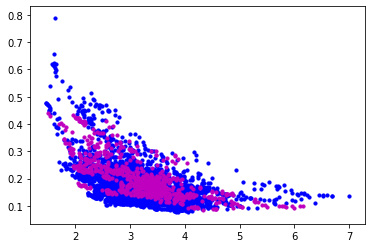

In [66]:
plt.scatter(comp[np.repeat(ytrain['label'][:100]==0,40)],mob[np.repeat(ytrain['label'][:100]==0,40)],color='b',s=10)
plt.scatter(comp[np.repeat(ytrain['label'][:100]==1,40)],mob[np.repeat(ytrain['label'][:100]==1,40)],color='m',s=10)

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [100]:
X = np.vstack((act,mob,comp)).T
print(X.shape)
y = np.repeat(ytrain['label'][:100],40)
xtrain,xtest,y_train,ytest = train_test_split(X,y.values,test_size = 0.3)
rf = RandomForestClassifier()
rf.fit(xtrain,y_train)
rf.score(xtest,ytest)

(4000, 3)


/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8433333333333334

In [105]:
np.sum(y_train)

558

In [106]:
1-np.sum(ytest)/len(ytest)

0.7983333333333333

In [109]:
np.unique(rf.predict(xtest),return_counts=True)

(array([0, 1]), array([1048,  152]))

In [110]:
np.unique(ytest,return_counts=True)

(array([0, 1]), array([958, 242]))

In [123]:
from sklearn.metrics import confusion_matrix

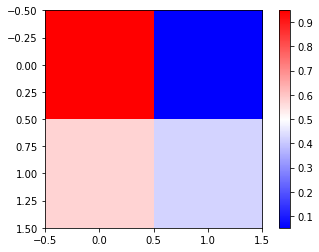

In [133]:
m = confusion_matrix(ytest,rf.predict(xtest),labels=[0,1])
plt.imshow((m.T/np.sum(m.T,axis=0)).T,cmap='bwr')
plt.colorbar()
plt.show()

In [132]:
(m.T/np.sum(m.T,axis=0)).T

array([[0.94885177, 0.05114823],
       [0.57438017, 0.42561983]])

In [135]:
from sklearn.metrics import roc_curve

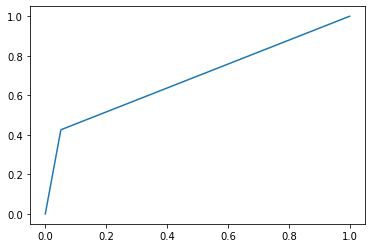

In [137]:
tpr,fpr,_ = roc_curve(ytest,rf.predict(xtest))
plt.plot(tpr,fpr)